In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2


In [2]:
# model = coralme.io.json.load_json_me_model("../ACCELERATE/models/pputida-2024_05_20/KT2440-UPF36-DLKcat-Transport10.json")

### Load predictions

In [3]:
# fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-R2A.csv",index_col=0)
# fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-M9.csv",index_col=0)
fluxes = pandas.read_csv("./predictions/KT2440-UPF36-M9.csv",index_col=0)

In [4]:
pred = fluxes[fluxes.index.str.contains("translation_")]["fluxes"]*1e9
pred.name = "predicted"
pred.index = [r.split("translation_")[-1] for r in pred.index]

### Load omics data

In [21]:
rna = pandas.read_csv("./data-jul-2024/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [22]:
ribo = pandas.read_csv("./data-jul-2024/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [23]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
te_samples = [i + "_te" for i in samples]
all_samples = samples+rna_samples+te_samples+["predicted"]
colors = ["#2b83ba","#66bd63","#fdae61"]

### Load Annotation

In [24]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0)

### Combine results

In [25]:
NormalizedRibo = ribo.div(ribo.sum())*1e6
NormalizedRNA = rna.div(rna.sum())*1e6
NormalizedTE = NormalizedRibo.div(NormalizedRNA,axis=0)
Results = NormalizedRibo.join(NormalizedRNA,rsuffix="_rna").join(NormalizedTE,rsuffix="_te").join(pred)
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem
PP_0001,115.346129,101.379836,117.392753,0.428368,1.142857,1.386889,269.268957,88.707377,84.644676,NaN,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN
PP_0010,649.987487,654.840617,574.275588,0.870122,2.032432,1.871958,747.007359,322.195592,306.777985,NaN,PP_RS00050,dnaA,chromosomal replication initiator protein DnaA,CDS,1521.0,NaN
PP_0097,20.691063,14.890996,21.743415,0.053546,0.358301,0.321102,386.416850,41.560009,67.714909,NaN,PP_RS00495,NaN,YheV family putative zinc ribbon protein,CDS,282.0,NaN
PP_0947,32.817598,33.777137,39.853891,0.087012,0.129730,0.136639,377.160906,260.365490,291.672262,NaN,PP_RS04975,NaN,ZIP family metal transporter,CDS,894.0,NaN
PP_0948,14.117067,14.164606,29.334633,0.046853,0.098842,0.109311,301.307316,143.306005,268.358322,NaN,PP_RS04980,NaN,HPr family phosphocarrier protein,CDS,273.0,NaN


###  Group by subsystem

In [26]:
ResultsGrouped = ResultsAnnotated[rna_samples+samples+["predicted","subsystem"]].groupby("subsystem").sum()
ResultsGrouped[te_samples] = ResultsGrouped[samples].div(ResultsGrouped[rna_samples].rename(columns={i:j for i,j in zip(rna_samples,samples)}),axis=1)

In [27]:
ResultsGrouped["predicted"] = ResultsGrouped["predicted"] + 1

### Ribo

In [28]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
from scipy.stats import pearsonr

In [35]:
import cobra
cobra.__version__

'0.26.3'

PearsonRResult(statistic=0.7338982395725703, pvalue=1.9940451249586296e-47)


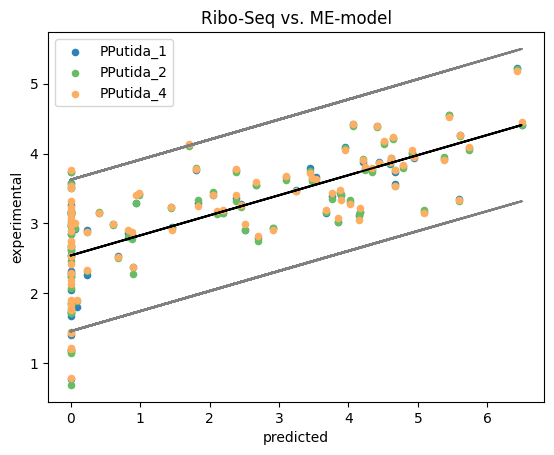

In [29]:
slist = samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
# colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))


# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("Ribo-Seq vs. ME-model")

plt.savefig("./figures/riboseq-cpm-bysubsystem-performance.svg",format="svg")

In [30]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/ribo-memodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,3.120379,2.648156,4.815559,3.731858,4.144994
Metabolic: No subsystem,PPutida_2,3.111053,2.648156,4.815559,3.731858,4.144994
Metabolic: No subsystem,PPutida_4,3.052351,2.648156,4.815559,3.731858,4.144994
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,0.766461,1.455843,3.624674,2.540259,0.000000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,0.687245,1.455843,3.624674,2.540259,0.000000


### RNA

PearsonRResult(statistic=0.6882463374644142, pvalue=1.1873556721638115e-39)


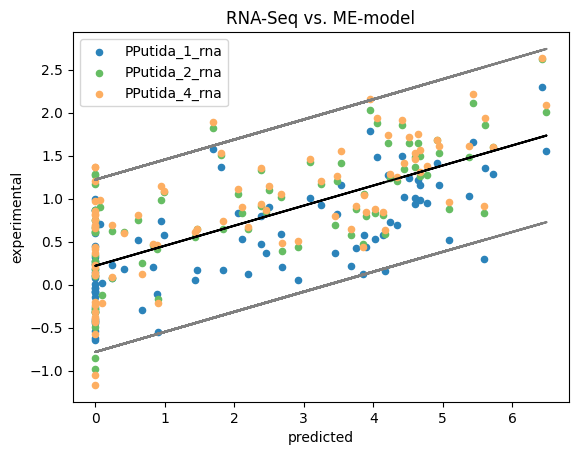

In [31]:
slist = rna_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("RNA-Seq vs. ME-model")

plt.savefig("./figures/rnaseq-cpm-bysubsystem-performance.svg",format="svg")

In [32]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/rna-memodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,0.573825,0.184969,2.187124,1.186046,4.144994
Metabolic: No subsystem,PPutida_2,0.804500,0.184969,2.187124,1.186046,4.144994
Metabolic: No subsystem,PPutida_4,0.848225,0.184969,2.187124,1.186046,4.144994
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,-0.540895,-0.782205,1.221269,0.219532,0.000000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,-0.978731,-0.782205,1.221269,0.219532,0.000000


## TE

PearsonRResult(statistic=0.3579570591924463, pvalue=1.1271684448699938e-09)


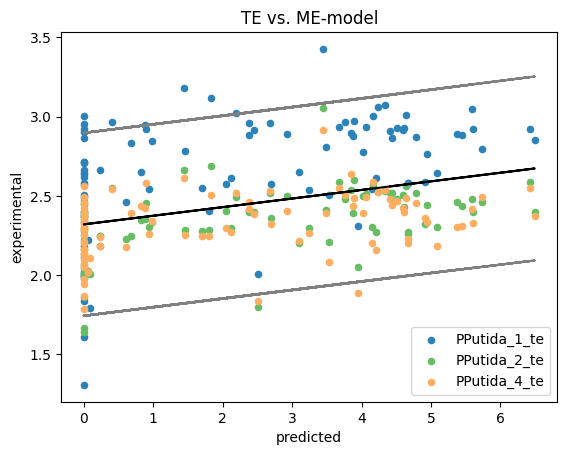

In [33]:
slist = te_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("TE vs. ME-model")

plt.savefig("./figures/te-cpm-bysubsystem-performance.svg",format="svg")

In [34]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/te-memodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,2.546555,1.968885,3.122738,2.545811,4.144994
Metabolic: No subsystem,PPutida_2,2.306553,1.968885,3.122738,2.545811,4.144994
Metabolic: No subsystem,PPutida_4,2.204126,1.968885,3.122738,2.545811,4.144994
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,1.307355,1.743420,2.898033,2.320727,0.000000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,1.665976,1.743420,2.898033,2.320727,0.000000


# By sample

### Ribo

PearsonRResult(statistic=0.7348367379442069, pvalue=1.1199789117586128e-16)
PearsonRResult(statistic=0.7366240722752422, pvalue=8.657405616087823e-17)
PearsonRResult(statistic=0.7304642840227344, pvalue=2.084546570499492e-16)


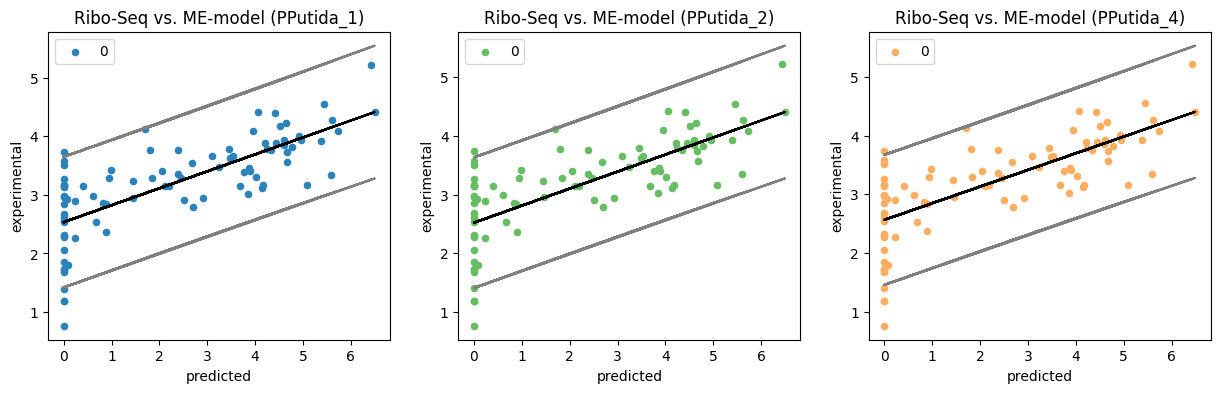

In [19]:
slist = samples
s = 0
fig,ax = plt.subplots(1,3,figsize=(15,4))
for idx,sample in enumerate(slist):
    a = ax[idx]
    tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
    # colors = ["brown","blue","green"]
    X = tmp["predicted"].values
    y = tmp[sample].values
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    tmp.plot.scatter("predicted",s,ax=a,color=colors[idx],label=s)
    a.plot(X,est2.predict(),color="black")
    a.set_ylabel("experimental")
    print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))
    
    # Confidence interval
    st, data, ss2 = summary_table(est2, alpha=0.05)
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    a.plot(X, predict_ci_low, color="gray")
    a.plot(X, predict_ci_upp, color="gray")
    a.set_title("Ribo-Seq vs. ME-model ({})".format(sample))

### TE

PearsonRResult(statistic=0.4625538426404814, pvalue=3.909997302643109e-06)
PearsonRResult(statistic=0.45933000752432296, pvalue=4.654598329025443e-06)
PearsonRResult(statistic=0.34807830795812694, pvalue=0.0007223982550192499)


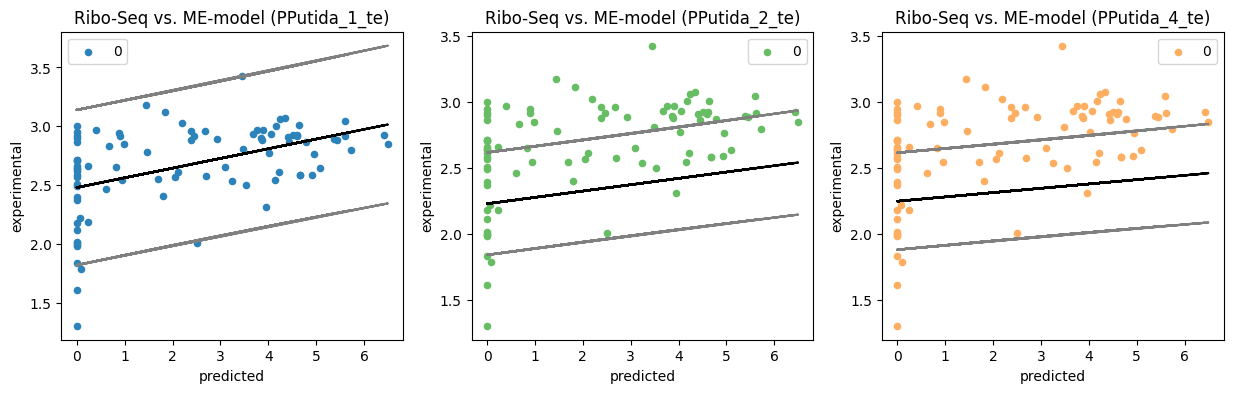

In [20]:
slist = te_samples
s = 0
fig,ax = plt.subplots(1,3,figsize=(15,4))
for idx,sample in enumerate(slist):
    a = ax[idx]
    tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
    # colors = ["brown","blue","green"]
    X = tmp["predicted"].values
    y = tmp[sample].values
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    tmp.plot.scatter("predicted",s,ax=a,color=colors[idx],label=s)
    a.plot(X,est2.predict(),color="black")
    a.set_ylabel("experimental")
    print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))
    
    # Confidence interval
    st, data, ss2 = summary_table(est2, alpha=0.05)
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    a.plot(X, predict_ci_low, color="gray")
    a.plot(X, predict_ci_upp, color="gray")
    a.set_title("Ribo-Seq vs. ME-model ({})".format(sample))

### Subsystems

In [197]:
def calculate_score(df,cutoff=100):
    experimental = df[df>cutoff].any(axis=1)
    experimental.name = "experimental"
    predicted = df["predicted"]>1e-16
    results = pandas.concat([experimental,predicted],axis=1)

    TP = results[(results["experimental"] == True) & (results["predicted"] == True)].shape[0]
    TN = results[(results["experimental"] == False) & (results["predicted"] == False)].shape[0]
    FP = results[(results["experimental"] == False) & (results["predicted"] == True)].shape[0]
    FN = results[(results["experimental"] == True) & (results["predicted"] == False)].shape[0]

    T = TP + FN
    N = TN + FP
    
    dct =  {"TP":TP,"TN":TN,"FP":FP,"FN":FN}
    dct["TPR"] = TP/T if T else numpy.nan
    dct["TNR"] = TN/N if N else numpy.nan
    dct["FDR"] = FP/(TP+FP)
    dct["FOR"] = FN/(TN+FN)
    dct["BA"] = (dct["TPR"] + dct["TNR"])/2
    dct["MCC"] = numpy.sqrt(dct["TPR"]*dct["TNR"]*(1-dct["FDR"])*(1-dct["FOR"]))
    return dct,results

<Axes: >

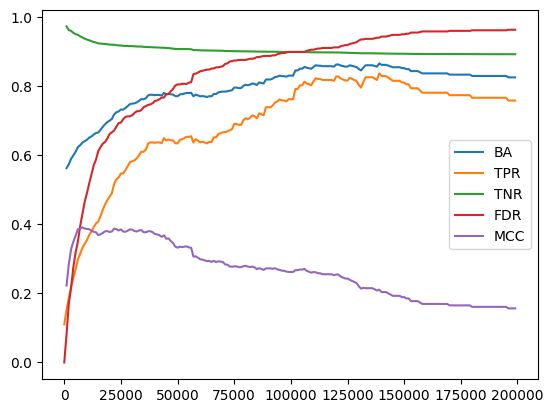

In [199]:
Res = {}
for i in range(0,200000,1000):
    dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]],cutoff=i)
    Res[i] = dct
pandas.DataFrame.from_dict(Res).T[["BA","TPR","TNR","FDR","MCC"]].plot()

<Axes: >

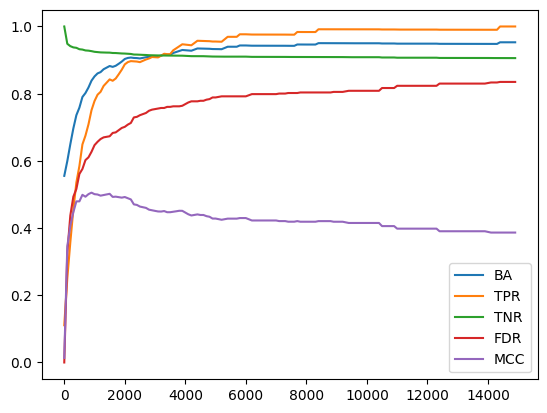

In [182]:
Res = {}
for i in range(0,15000,100):
    dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]],cutoff=i)
    Res[i] = dct
pandas.DataFrame.from_dict(Res).T[["BA","TPR","TNR","FDR","MCC"]].plot()

In [200]:
pandas.DataFrame.from_dict(Res)

,0,1000,2000,3000,4000,5000,6000,7000,8000,9000,...,190000,191000,192000,193000,194000,195000,196000,197000,198000,199000
TP,606.000000,557.000000,503.000000,475.000000,439.000000,413.000000,394.000000,367.000000,346.000000,324.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,22.000000,22.000000,22.000000,22.000000
TN,0.000000,1773.000000,2656.000000,3177.000000,3515.000000,3752.000000,3943.000000,4069.000000,4175.000000,4251.000000,...,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000
FP,0.000000,49.000000,103.000000,131.000000,167.000000,193.000000,212.000000,239.000000,260.000000,282.000000,...,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,584.000000,584.000000,584.000000,584.000000
FN,4870.000000,3097.000000,2214.000000,1693.000000,1355.000000,1118.000000,927.000000,801.000000,695.000000,619.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
TPR,0.110665,0.152436,0.185131,0.219096,0.244705,0.269758,0.298259,0.314212,0.332373,0.343584,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.758621,0.758621,0.758621,0.758621
TNR,NaN,0.973106,0.962668,0.960399,0.954644,0.951077,0.948977,0.944522,0.941375,0.937790,...,0.892949,0.892949,0.892949,0.892949,0.892949,0.892949,0.892785,0.892785,0.892785,0.892785
FDR,0.000000,0.080858,0.169967,0.216172,0.275578,0.318482,0.349835,0.394389,0.429043,0.465347,...,0.962046,0.962046,0.962046,0.962046,0.962046,0.962046,0.963696,0.963696,0.963696,0.963696
FOR,1.000000,0.635934,0.454620,0.347639,0.278234,0.229569,0.190349,0.164476,0.142710,0.127105,...,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437
BA,NaN,0.562771,0.573899,0.589747,0.599674,0.610418,0.623618,0.629367,0.636874,0.640687,...,0.829808,0.829808,0.829808,0.829808,0.829808,0.829808,0.825703,0.825703,0.825703,0.825703
MCC,NaN,0.222795,0.284037,0.328018,0.349491,0.367030,0.385998,0.387520,0.391345,0.387781,...,0.161076,0.161076,0.161076,0.161076,0.161076,0.161076,0.156693,0.156693,0.156693,0.156693


In [201]:
dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]],cutoff=1000)
dct

{'TP': 557,
 'TN': 1773,
 'FP': 49,
 'FN': 3097,
 'TPR': 0.15243568691844553,
 'TNR': 0.9731064763995609,
 'FDR': 0.08085808580858085,
 'FOR': 0.6359342915811088,
 'BA': 0.5627710816590032,
 'MCC': 0.22279461019422553}

In [163]:
dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]],cutoff=12000)
dct

{'TP': 107,
 'TN': 4869,
 'FP': 499,
 'FN': 1,
 'TPR': 0.9907407407407407,
 'TNR': 0.9070417287630402,
 'BA': 0.9488912347518905}

In [ ]:
dct = {}
results = {}
for subsystem in ResultsAnnotated["subsystem"].unique():
    df = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)]
    dct[subsystem],results[subsystem] = calculate_score(df[samples+["predicted"]])
RiboSeqScore = pandas.DataFrame.from_dict(dct).T

In [ ]:
RiboSeqScore

In [ ]:
dct = {}
results = {}
for subsystem in ResultsAnnotated["subsystem"].unique():
    df = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)]
    dct[subsystem],results[subsystem] = calculate_score(df[rna_samples+["predicted"]])
RNASeqScore = pandas.DataFrame.from_dict(dct).T

In [ ]:
RNASeqScore

In [ ]:
dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]])
dct

In [ ]:
dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]])
dct

In [ ]:
RNASeqScore.sort_values("TP",ascending=False)

In [ ]:
subsystem = "Metabolic:S_Cofactor_and_Prosthetic_Group_Biosynthesis"

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("PPutida_1",ascending=False)

In [ ]:
lst = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("PPutida_1",ascending=False).index

In [ ]:
lst

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("predicted",ascending=False)

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains("Metabolic:S_Transport__Outer_Membrane")][samples+rna_samples].plot.box(figsize=(10,5))

In [ ]:
tmp = numpy.log10(ResultsGrouped).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
slist = rna_samples
colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],alpha=0.5)
plt.ylabel("experimental")
plt.plot(X,est2.predict(),color="black")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

In [ ]:
ypred = est2.predict()
yerr = y-ypred
errors = pandas.Series({i:j for i,j in zip(tmp[slist].stack().index,yerr)})
errors.reset_index().set_index("level_0").sort_values(0)